In [1]:
import prospectpredictor as pp
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pp

<module 'prospectpredictor' from 'c:\\workspace\\kobold\\prospectPredictor\\prospectpredictor\\__init__.py'>

# Prepare your Shapefiles

Start by loading a shape file into the PrepShapes class. This will load the file into a self.data attribute using geopandas

In [3]:
INPUT_FILE = "data/BedrockP.shp"
prepData = pp.PrepShapes(INPUT_FILE)

You have access to everything geopandas. Such as what's the CRS for this file?

In [4]:
prepData.data.crs

<Projected CRS: EPSG:26910>
Name: NAD83 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - 126°W to 120°W and NAD83 by country
- bounds: (-126.0, 30.54, -119.99, 81.8)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## Exploring the shape files

Now we can do some quick exploring. Lets first see what columns are loaded and look at what's in those columns

In [5]:
prepData.printColumns(maxLineLength=60)

|| gid || upid || area_m2 || strat_unit || era || period || 
|| strat_agestrat_name || gp_suite || fm_lithodm || 
|| mem_phaserock_class || rock_type || rk_char || 
|| unit_descage_max || age_min || belt || terrane || 
|| basinbasin_age || project || src_url || src_ref_s || 
|| map_compedit_date || pub_org || geometry || 


In [6]:
prepData.printUnique(include=['rock_class', 'rock_type'], maxLineLength=80)

rock_class 
--------
|| volcanic rocks || sedimentary rocks || intrusive rocks || 
|| ultramafic rocksmetamorphic rocks || 


rock_type 
--------
|| coarse volcaniclastic and pyroclastic volcanic rocks || 
|| marine sedimentary and volcanic rocks
|| mudstone, siltstone, shale fine clastic sedimentary rocks
|| basaltic volcanic rocksundivided sedimentary rocks || 
|| andesitic volcanic rocksfeldspar porphyritic intrusive rocks || 
|| granodioritic intrusive rocksultramafic rocks || 
|| quartz dioritic intrusive rocks
|| granite, alkali feldspar granite intrusive rocks
|| serpentinite ultramafic rockscoarse clastic sedimentary rocks || 
|| undivided volcanic rocksdioritic intrusive rocks || 
|| greenstone, greenschist metamorphic rocksorthogneiss metamorphic rocks || 
|| argillite, greywacke, wacke, conglomerate turbidites
|| quartz monzonitic intrusive rockscalc-alkaline volcanic rocks || 
|| mid amphibolite/andalusite grade metamorphic rocks
|| rhyolite, felsic volcanic rocks
|| conglo

We can also plot the shapes and have the polygons colored / grouped by the values in a column. lets look at the "rock_class" category

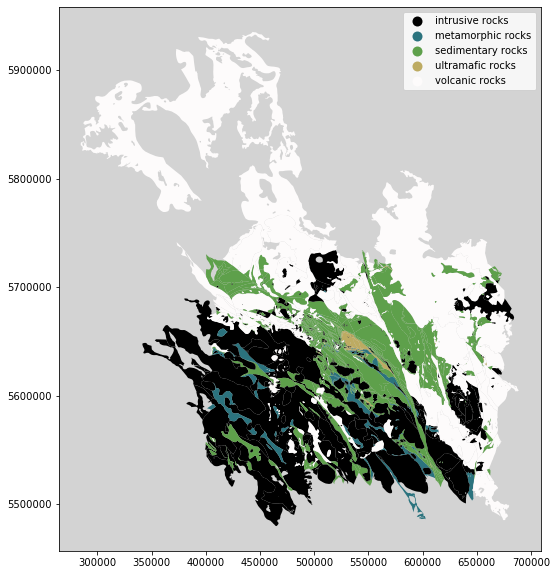

In [7]:
ax = prepData.plotData("rock_class")
ax.set_facecolor('lightgrey')

We've done a bit of exploring. we could explore different columns but for know I know I want to make some predictions later based on how close a location is to both 'granodioritic intrusive rocks' and 'ultramafic rocks'. 

So lets set up the shapes we'll use for the predictor class and print the plot above but with the shape outlines on them

In [8]:
shpNmColDict = {'granodioritic intrusive rocks': 'rock_type', 'ultramafic rocks':'rock_class'}
prepData.setShapes(shpNmColDict)

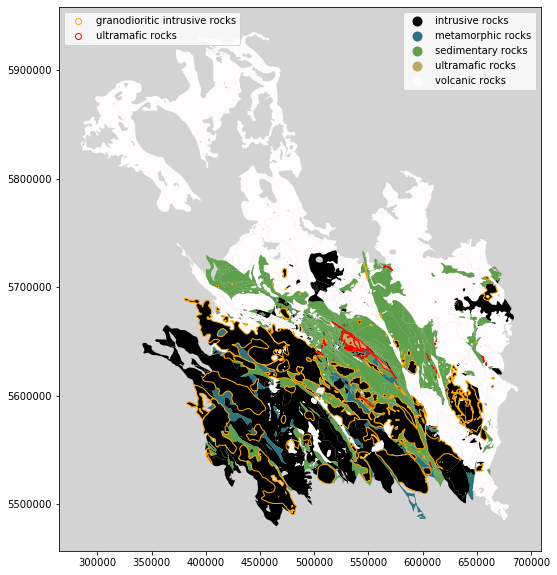

In [9]:
ax = prepData.plotData("rock_class")
ax.set_facecolor('lightgrey')
ax = prepData.plotShapes(ax=ax, color=['orange', 'red'])

For the predictor class. there are a few things that will make the process easir. First we can dissolve the selected shapes. Second we can created a buffer around the shapes and use that to set up a minimum sized project boundary. Later down the road we'll use the project boundary to set up the extents for our prediction raster (no sense in predicting in locations where we know we are way outside range of our predictor from the shapes of interest).

Here I suggest setting the buffer size to roughly 10%-20% the range you want to use in the predictor

In [10]:
# dissolve the data
prepData.dissolveData()

In [11]:
# set buffer size
prepData.setBuffer(12000) # 12 km buffer
prepData.boundaryBuffer

12000

In [12]:
# create the buffer
prepData.bufferData()

In [13]:
# determine minimum project boundary
prepData.setProjectBoundary()
prepData.projBounds

,minx,miny,maxx,maxy
0,489327.059775,5.519925e+06,672302.831074,5.733139e+06


Lets check our work. we can do a quick plot first of the buffer we created then of the plot above but zoomed into the project boundary

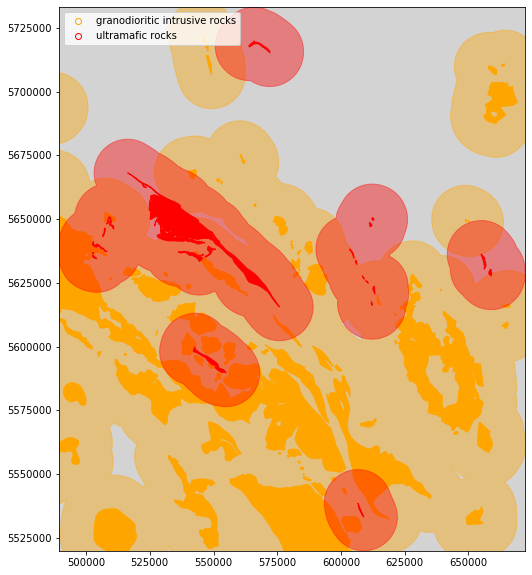

In [14]:
# plot the buffered shapes
ax = prepData.plotShapes(useProjBounds=True, color=['orange', 'red'],
                         plotBuffer=True, polyfill=True, bAlpha=0.4)
ax.set_facecolor('lightgrey')

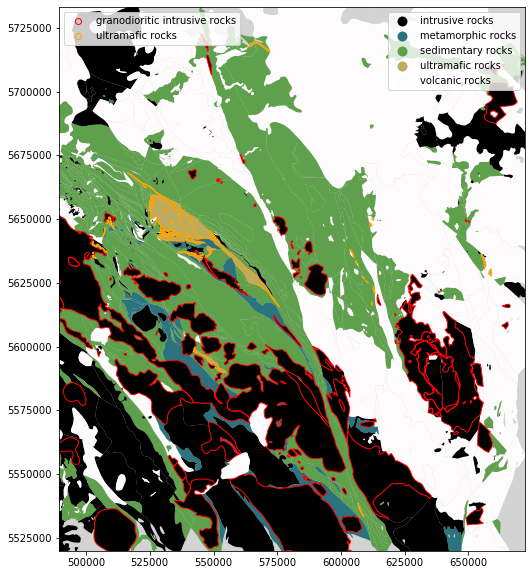

In [15]:
# plot the rock class units and shapes of interest zoomed into the project boundary
ax = prepData.plotData("rock_class")
ax.set_facecolor('lightgrey')
ax = prepData.plotShapes(ax=ax, useProjBounds=True)

In [16]:
# just as a reminder we will print out the shape names that are our shapes of interest
list(prepData.shapeNameColDict.keys())

['granodioritic intrusive rocks', 'ultramafic rocks']

In [17]:
prepData.data.crs.to_string()

'EPSG:26910'

# Set up a raster template for the predictor class

Now we need to set up a quick raster template. We'll use the projBounds found earlier to help set up the shape, size, and transform for our raster

For the transform we need to also have any idea of what cell size we'll be using in our raster. Lets use a cell size of 500 meters by 500 meters

In [18]:
rtemplate = pp.RasterTemplate(prepData.projBounds, 500, 500, crs=prepData.data.crs.to_string())

# Predict!

we'll initialize the predictor, then predict!

In [19]:
predictor = pp.PredictorByDistance(prepData, rtemplate, archRange=10000) # Range of 10 km

In [20]:
# we can check the size of the prediction raster if we are curious
predictor.predictRaster.shape

(427, 366)

In [21]:
predictor.predict()

Now lets see what we predicted!

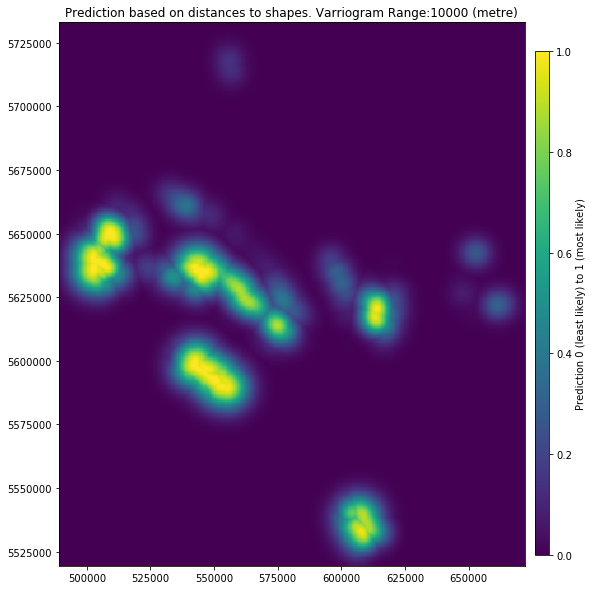

In [22]:
predictor.plotPrediction()

Not all that helpful so lets plot some shapes as well

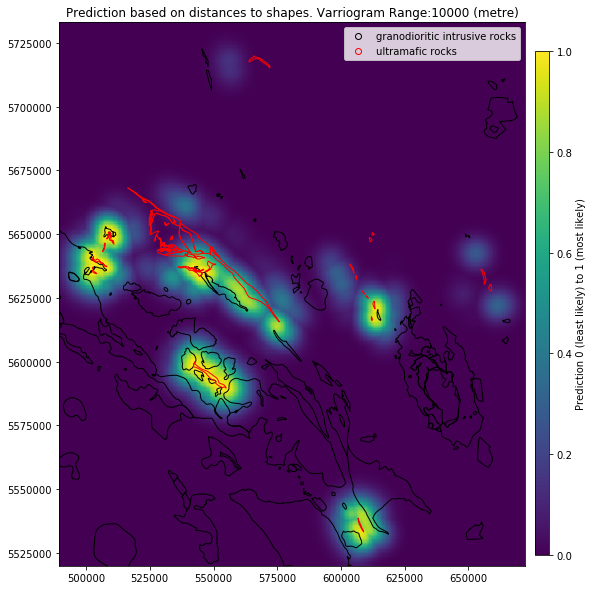

In [23]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))

ax = predictor.plotPrediction(ax=ax)
ax = prepData.plotShapes(ax=ax, color=['black', 'red'], useProjBounds=True, legLoc='upper right')

That's pretty cool and seems to make sense. But lets do some other quick checks. We can see also plot each of the distance matrix's to see if they make sense as well.

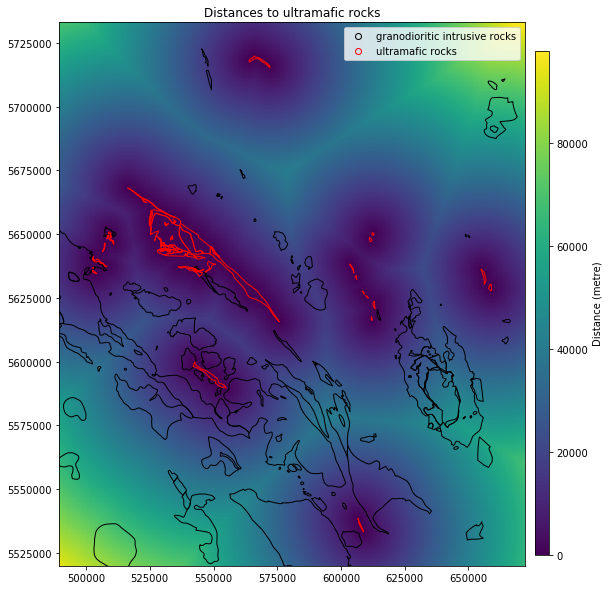

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))

ax = predictor.plotDistance('ultramafic rocks', ax=ax)
ax = prepData.plotShapes(ax=ax, color=['black', 'red'], useProjBounds=True, legLoc='upper right')

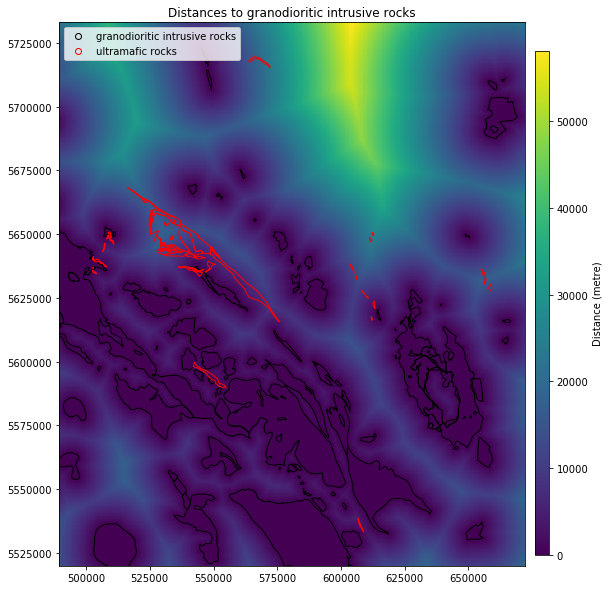

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))

ax = predictor.plotDistance('granodioritic intrusive rocks', ax=ax)
ax = prepData.plotShapes(ax=ax, color=['black', 'red'], useProjBounds=True, legLoc='upper left')

# Save out the prediction and distance rasters

Ok we made some predictions.. now lets save out our current prediction model so we don't lose what we have. We can save out just the prediction raster or save everything. might as well save it all.

In [26]:
predictor.saveRaster('range10km', bands='all')

At this point, I might get some quick stats and then reload the data and double check to make sure the loaded data matches what I'm saving

In [27]:
idx1 = np.unravel_index(np.argmax(predictor.distRasters['granodioritic intrusive rocks'], axis=None), 
                       predictor.distRasters['granodioritic intrusive rocks'].shape)
maxval = predictor.distRasters['granodioritic intrusive rocks'][idx1]
dataMean = predictor.distRasters['granodioritic intrusive rocks'].mean()
dataShape = predictor.distRasters['granodioritic intrusive rocks'].shape

In [28]:
pred2 = pp.PredictorByDistance(prepData, rtemplate)
pred2.loadRaster('range10km', rasterType='all')

In [29]:
idx2 = np.unravel_index(np.argmax(pred2.distRasters['granodioritic intrusive rocks'], axis=None), 
                        pred2.distRasters['granodioritic intrusive rocks'].shape)
maxval2 = pred2.distRasters['granodioritic intrusive rocks'][idx1]
dataMean2 = pred2.distRasters['granodioritic intrusive rocks'].mean()
dataShape2 = pred2.distRasters['granodioritic intrusive rocks'].shape

In [30]:
print('                    old | new')
print(f'max val index: {idx1} | {idx2}')
print(f'max value: {maxval} | {maxval2}')
print(f'data mean: {dataMean} | {dataMean2}')
print(f'raster shape: {dataShape} | {dataShape2}')

                    old | new
max val index: (0, 230) | (0, 230)
max value: 58076.64453125 | 58076.64453125
data mean: 10663.6748046875 | 10663.6748046875
raster shape: (427, 366) | (427, 366)


# Save Pretty Plot

Lets go ahead and save out a nice couple of heatmaps with the 'rock_class' as our background shape.

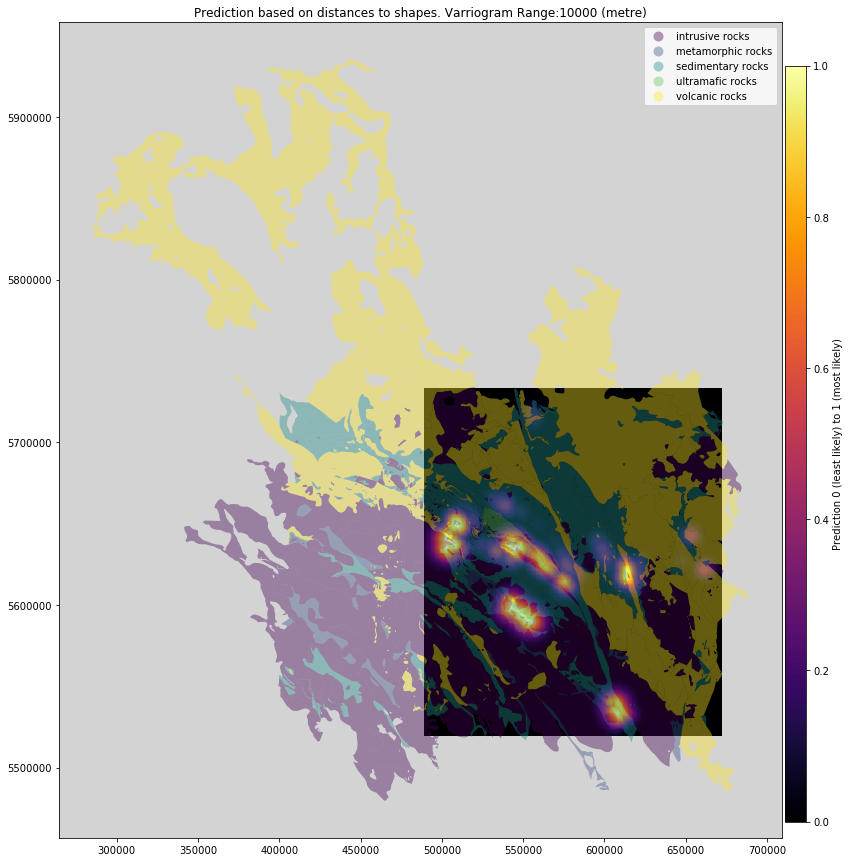

In [36]:
fig, ax = plt.subplots(figsize=(15, 15))
ax = pred2.plotPrediction(ax=ax, cmap='inferno')
ax = prepData.plotData(column='rock_class', cmap='viridis', ax=ax, kwds={'alpha':0.4})
ax.set_facecolor('lightgrey')
plt.savefig('data/predictionHeatMap.png', dpi=300, bbox_inches='tight')

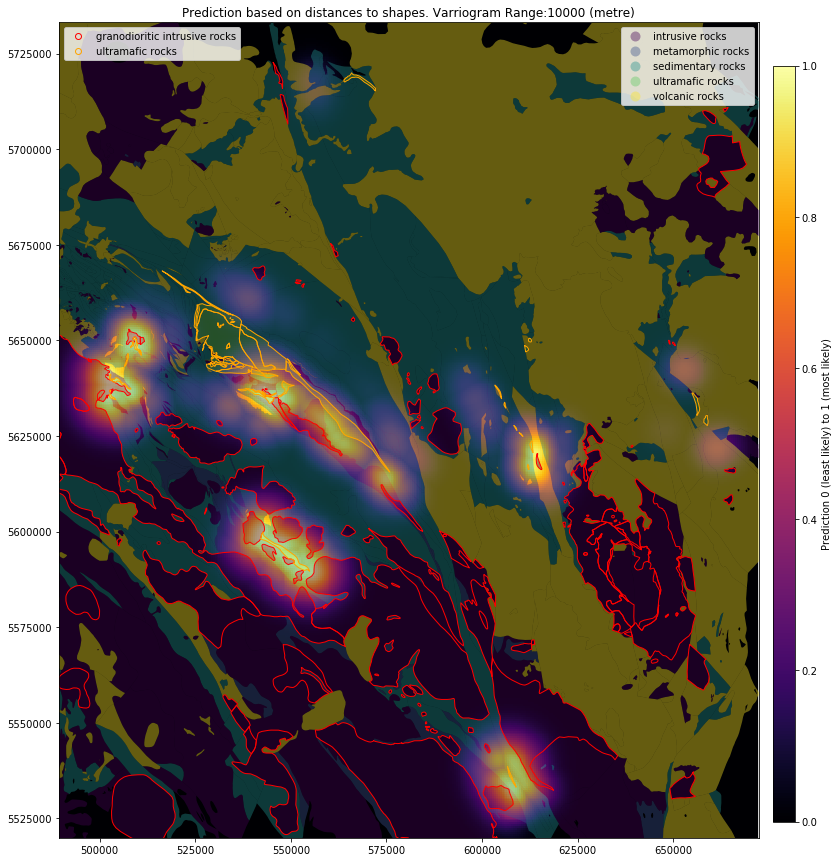

In [37]:
fig, ax = plt.subplots(figsize=(15, 15))
ax = pred2.plotPrediction(ax=ax, cmap='inferno')
ax = prepData.plotData(column='rock_class', cmap='viridis', ax=ax, kwds={'alpha':0.4})
ax.set_facecolor('lightgrey')
ax = prepData.plotShapes(ax=ax, useProjBounds=True)
plt.savefig('data/predictionHeatMap_projectBoundary.png', dpi=300, bbox_inches='tight')